# LSTM Model for Time Series Forecasting: Predicting Financial Data

In this project, we will create an LSTM (Long Short-Term Memory) model to predict the future `CLOSE` price of a financial asset like bitcoin based on past data such as trading volume, market capitalization, and other related indicators.

## Steps:
1. Load and preprocess the data.
2. Normalize the data for better performance.
3. Prepare the data for the LSTM model.
4. Build the LSTM model.
5. Train the model.
6. Evaluate the model and make predictions.


In [2]:
# Step 1: Load and preprocess the data

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'lstm_variables.csv'
data = pd.read_csv(file_path, delimiter='\t')

# Check for missing values
print("Missing values in the dataset:")
print(data.isnull().sum())

# Fill or drop missing values if necessary (for now, we will drop any rows with NaNs)
data = data.dropna()

# Display the first few rows
data.head()


Missing values in the dataset:
CLOSE            0
HIGH             0
LOW              0
VOLUME           0
MARKETCAP        0
GSADF            0
HASHRATE         0
TRANSFEES        0
FGI              0
CONFIRMTIME      0
MININGREVENUE    0
dtype: int64


,CLOSE,HIGH,LOW,VOLUME,MARKETCAP,GSADF,HASHRATE,TRANSFEES,FGI,CONFIRMTIME,MININGREVENUE
0,7200.17,7254.33,7174.94,18565664997,1.303941e+11,-0.233621,1.127185e+08,9.971000,37,6.226406,1.590708e+07
1,6985.47,7212.16,6935.27,20802083465,1.304230e+14,-0.430629,9.671772e+07,13.780845,39,14.228962,1.257613e+07
2,7344.88,7413.72,6915.00,28111481032,1.262808e+11,-0.397457,1.159241e+08,16.389795,38,11.000906,1.570559e+07
3,7410.66,7427.39,7309.51,18444271275,1.327663e+11,-0.488832,1.152381e+08,12.312165,38,9.868912,1.565093e+07
4,7411.32,7544.50,7400.54,19725074095,1.334747e+11,-0.802474,1.118084e+08,11.887112,39,8.827705,1.540440e+07


### Dataset Description

The dataset consists of financial indicators for an asset. Below is a brief description of each column:

- **CLOSE**: The closing price of the asset at the end of the trading period.
- **HIGH**: The highest price of the asset during the trading period.
- **LOW**: The lowest price of the asset during the trading period.
- **VOLUME**: The total volume of the asset traded during the period.
- **MARKETCAP**: The market capitalization of the asset, representing its total value in the market.
- **GSADF**: Generalized Supremum Augmented Dickey-Fuller (GSADF) statistic, a test for detecting asset price bubbles.
- **HASHRATE**: The computational power used in cryptocurrency mining.
- **TRANSFEES**: Transaction fees collected in the cryptocurrency network during the period.
- **FGI**: Fear and Greed Index, a measure of market sentiment.
- **CONFIRMTIME**: The time taken to confirm transactions on the blockchain network.
- **MININGREVENUE**: The revenue earned from mining operations during the period.

We will use this data to build an LSTM model for predicting the future **CLOSE** prices based on the other variables.


### Step 2: Data Normalization

LSTM models perform better when the input data is scaled to a smaller range. We will normalize the data between 0 and 1 using MinMaxScaler.


In [3]:
# Step 2: Normalize the data

scaler = MinMaxScaler(feature_range=(0, 1))

# We will normalize all columns except for the target 'CLOSE' separately
scaled_data = scaler.fit_transform(data)

# Separate features (X) and the target variable (y)
X = scaled_data[:, 1:]  # All columns except 'CLOSE'
y = scaled_data[:, 0]   # 'CLOSE' column is the target

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


### Step 3: Prepare the Data for the LSTM

LSTM models expect the data to be in the form of sequences, where the input is a series of data points (timesteps). We will reshape the data accordingly, with each input sequence consisting of a certain number of past data points that will be used to predict the next data point.


In [4]:
# Step 3: Prepare data for LSTM

def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

# Reshape the data to be 3-dimensional for LSTM (samples, time steps, features)
print(f"Training data shape: {X_train_seq.shape}")
print(f"Testing data shape: {X_test_seq.shape}")


Training data shape: (817, 60, 10)
Testing data shape: (160, 60, 10)


### Step 4: Build the LSTM Model

We will now create the LSTM model using Keras. The model will consist of LSTM layers followed by Dense layers to output the predictions.


In [6]:
# Step 4: Build the LSTM model

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()

# Add LSTM layer with Dropout to avoid overfitting
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,451 (126.76 KB)

 Trainable params: 32,451 (126.76 KB)

 Non-trainable params: 0 (0.00 B)

### Step 5: Train the Model

We will now train the model using the training data. The model will learn to predict the `CLOSE` price based on the historical data.


In [5]:
# Step 5: Train the model

history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64, verbose = 0, validation_data=(X_test_seq, y_test_seq))


### Step 6: Evaluate Model Performance (Loss Curves)

We will first visualize the training and validation loss over time to understand how well the model performed during training.


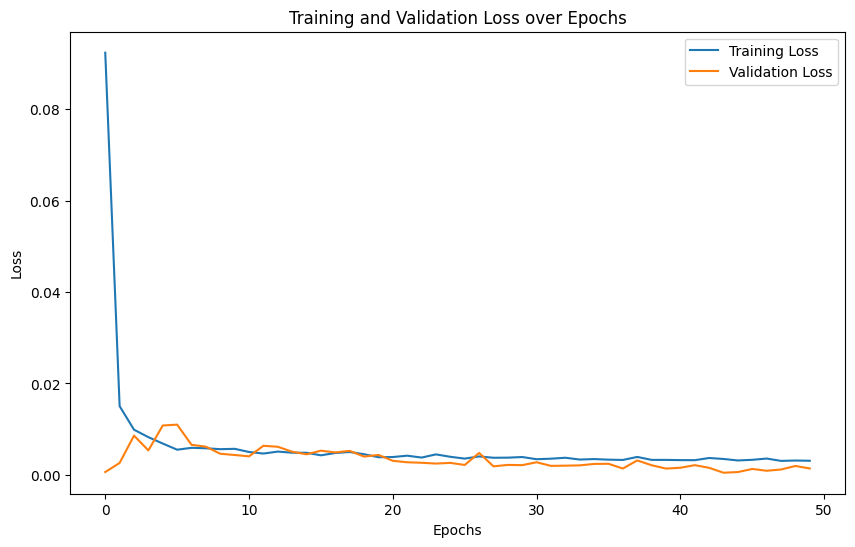

In [6]:
# Step 6: Plot Training and Validation Loss

# Plot the loss curves for training and validation
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Step 7: Evaluate Model Performance using MSE and MAE

After training the model, we will calculate the and **Mean Absolute Error (MAE)** to measure how well the model is performing on the test data.


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 7: Make predictions with the model and then calculate MSE and MAE

# Generate predictions on the test set
y_pred = model.predict(X_test_seq)

# Rescale the predicted and actual CLOSE prices back to original scale
y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], X_test_seq.shape[2]))), axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test_seq.reshape(-1, 1), np.zeros((y_test_seq.shape[0], X_test_seq.shape[2]))), axis=1))[:, 0]

# Calculate and MAE on the rescaled data (in original Bitcoin value)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f"Mean Absolute Error (MAE): {mae}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Mean Absolute Error (MAE): 2110.527407333851


### Step 8: Model Evaluation and Predictions

We will now evaluate the model on the test data and visualize the predictions vs the actual values. This will help us understand how well the LSTM model can predict the future `CLOSE` prices.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


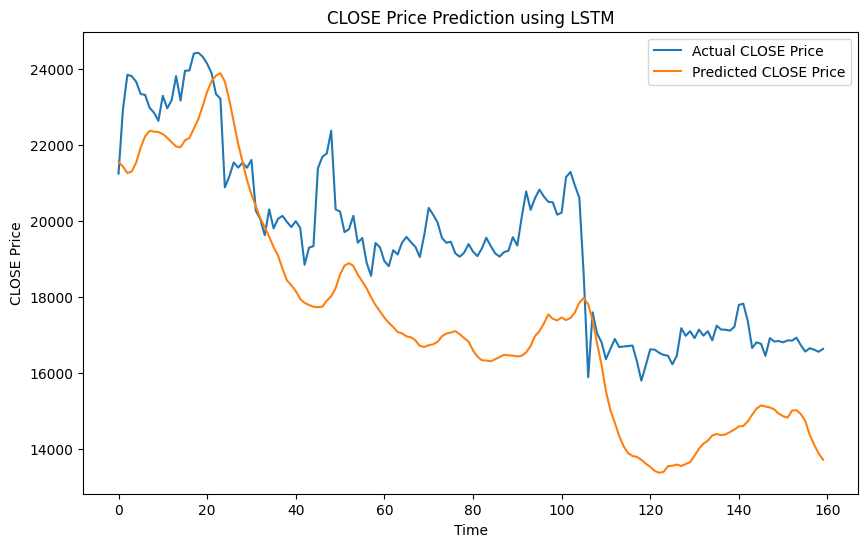

In [8]:
# Step 8: Evaluate the model and make predictions

# Predictions on the test set
y_pred = model.predict(X_test_seq)

# Rescale the predicted and actual CLOSE prices back to original scale
# We only want to inverse transform the 'CLOSE' values (the first column)
y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], X_test_seq.shape[2]))), axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test_seq.reshape(-1, 1), np.zeros((y_test_seq.shape[0], X_test_seq.shape[2]))), axis=1))[:, 0]

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='Actual CLOSE Price')
plt.plot(y_pred_rescaled, label='Predicted CLOSE Price')
plt.title('CLOSE Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('CLOSE Price')
plt.legend()
plt.show()


# Improving the LSTM Model for Time Series Forecasting with MAE Evaluation

We will explore three potential improvements to our LSTM model:
1. **Hyperparameter tuning**: Modifying LSTM units, dropout rate, and batch size.
2. **Adding more LSTM layers**: Increasing the depth of the model to capture complex patterns.
3. **Experimenting with optimizers**: Trying different optimizers such as `RMSprop`.

In each step, we will track the **Mean Absolute Error (MAE)** and **Mean Squared Error (MSE)** to see which modification provides the best performance. We will also plot the training and validation MAE alongside the loss curves for better comparison.


## Step 1: Hyperparameter Tuning

We will increase the number of LSTM units and adjust the dropout rate to see if this improves performance. Additionally, we will use a smaller batch size to see if it helps with convergence.


/home/nikos_pc/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


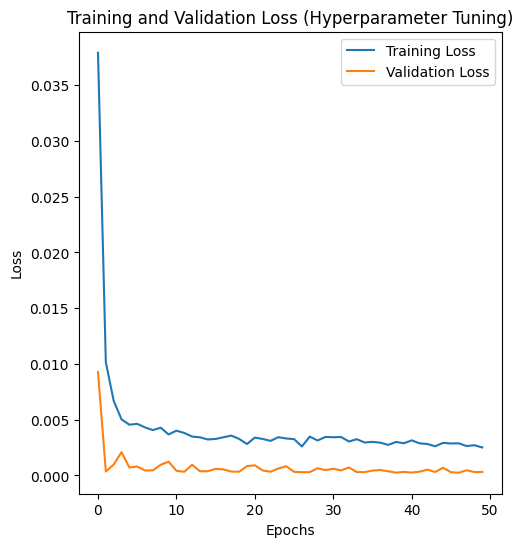

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Mean Absolute Error (MAE) in original scale (Bitcoin value) after Hyperparameter Tuning: 814.1678511086218


In [9]:
# Step 1: Modify the LSTM model architecture for hyperparameter tuning

model = Sequential()

# Increased number of units and dropout
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.3))

model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units=1))

# Compile the model with MAE as a metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model with a smaller batch size
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64, verbose=0, validation_data=(X_test_seq, y_test_seq))

# Plot the loss and MAE curves
plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Hyperparameter Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step: Rescale predictions and actual values back to original Bitcoin values
y_pred = model.predict(X_test_seq)

# Rescale the predicted and actual CLOSE prices back to original scale
y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], X_test_seq.shape[2]))), axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test_seq.reshape(-1, 1), np.zeros((y_test_seq.shape[0], X_test_seq.shape[2]))), axis=1))[:, 0]

# Calculate the Mean Absolute Error (MAE) on the rescaled data
mae_rescaled = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error (MAE) in original scale (Bitcoin value) after Hyperparameter Tuning: {mae_rescaled}")


## Step 2: Adding More LSTM Layers

We will add another LSTM layer to the model to help it capture more complex temporal patterns in the data.


/home/nikos_pc/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


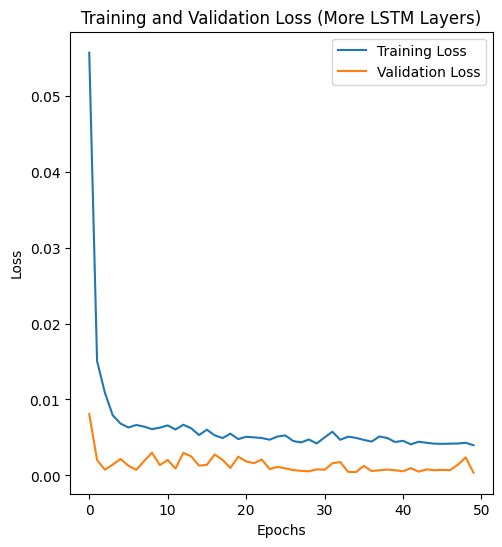

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Mean Absolute Error (MAE) in original scale (Bitcoin value) after Adding More LSTM Layers: 919.4533949084656


In [10]:
# Step 2: Modify the LSTM model architecture to add more layers

model = Sequential()

# Adding three LSTM layers with increased units and dropout
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.3))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units=1))

# Compile the model with MAE as a metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64, verbose=0, validation_data=(X_test_seq, y_test_seq))

# Plot the loss and MAE curves
plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (More LSTM Layers)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step: Rescale predictions and actual values back to original Bitcoin values
y_pred = model.predict(X_test_seq)

# Rescale the predicted and actual CLOSE prices back to original scale
y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], X_test_seq.shape[2]))), axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test_seq.reshape(-1, 1), np.zeros((y_test_seq.shape[0], X_test_seq.shape[2]))), axis=1))[:, 0]

# Calculate the Mean Absolute Error (MAE) on the rescaled data
mae_rescaled = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error (MAE) in original scale (Bitcoin value) after Adding More LSTM Layers: {mae_rescaled}")


### Step 3: Experimenting with Optimizers

Another layer increases the MAE, indicating that there is no need to further complicate the network. So we remove the second layer. Different optimizers can influence the convergence speed and final performance of the model. We will experiment with the `RMSprop` optimizer to see if it provides better results compared to `Adam`.


/home/nikos_pc/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


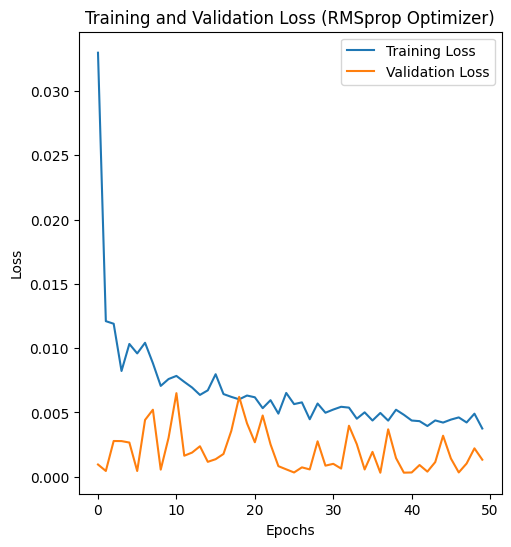

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Mean Absolute Error (MAE) in original scale (Bitcoin value) after Optimizer Change to RMSprop: 2103.141519359485


In [11]:
# Step 3: Change optimizer to RMSprop

model = Sequential()

# Same LSTM architecture
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.3))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(units=1))

# Compile the model with RMSprop and MAE as a metric
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64, verbose = 0, validation_data=(X_test_seq, y_test_seq))

# Plot the loss and MAE curves
plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (RMSprop Optimizer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step: Rescale predictions and actual values back to original Bitcoin values
y_pred = model.predict(X_test_seq)

# Rescale the predicted and actual CLOSE prices back to original scale
y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], X_test_seq.shape[2]))), axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test_seq.reshape(-1, 1), np.zeros((y_test_seq.shape[0], X_test_seq.shape[2]))), axis=1))[:, 0]

# Calculate the Mean Absolute Error (MAE) on the rescaled data
mae_rescaled = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error (MAE) in original scale (Bitcoin value) after Optimizer Change to RMSprop: {mae_rescaled}")


# Further Improvements to the LSTM Model for Bitcoin Price Prediction

After achieving significant improvement in performance through hyperparameter tuning, we will explore additional methods to further enhance the model. We will try Fine-tuning the learning rate.



We will now adjust the learning rate of the optimizer to a lower value, which might help improve the model’s performance by allowing it to make finer adjustments during training. This step helps avoid large updates that may overshoot the optimal weights.


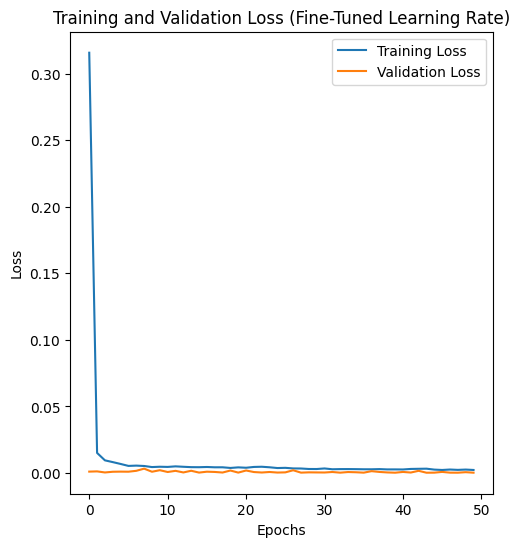

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Mean Absolute Error (MAE) in original Bitcoin value after fine-tuning learning rate: 790.9658975423202


In [12]:
from keras.optimizers import Adam

# Adjusting learning rate to a smaller value for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mae'])

# Re-train the model with a lower learning rate
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64, verbose=0, validation_data=(X_test_seq, y_test_seq))

# Plot the training/validation loss and MAE to observe any improvements
plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Fine-Tuned Learning Rate)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Rescale predictions and actual values, then calculate MAE in Bitcoin value
y_pred = model.predict(X_test_seq)
y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], X_test_seq.shape[2]))), axis=1))[:, 0]
mae_rescaled = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f"Mean Absolute Error (MAE) in original Bitcoin value after fine-tuning learning rate: {mae_rescaled}")


## Conclusion

We have managed to get the MAE below 800, which is not that good but we've seen progress. Feel free to experiment on your own!